In [1]:
import diffrax
import jax
import jax.numpy as jnp
import numpy as np
from jax import random
import matplotlib.pyplot as plt
import lineax as lx
import optimistix as optx

from pde_opt.numerics.domains import Domain
from pde_opt.numerics.equations import CahnHilliard2DPeriodic, AllenCahn2DPeriodic
from pde_opt.numerics.solvers import SemiImplicitFourierSpectral

In [2]:
# Often import when doing scientific work
jax.config.update("jax_enable_x64", True)


def fn(y, args):
    a, b = y
    c = jnp.tanh(jnp.sum(b)) - a
    d = a**2 - jnp.sinh(b + 1)
    return c, d


solver = optx.Newton(rtol=1e-8, atol=1e-8, linear_solver=lx.GMRES(rtol=1e-3, atol=1e-3))
y0 = (jnp.array(0.0), jnp.zeros((2, 2)))
sol = optx.root_find(fn, solver, y0)

In [3]:
print(sol.value)

(Array(-0.85650715, dtype=float64), Array([[-0.32002086, -0.32002086],
       [-0.32002086, -0.32002086]], dtype=float64))


In [15]:
Nx, Ny = 64, 64
Lx = 0.01 * Nx
Ly = 0.01 * Ny
domain = Domain((Nx, Ny), ((-Lx / 2, Lx / 2), (-Ly / 2, Ly / 2)), "dimensionless")

t_start = 0.0
t_final = 1.0
dt = 0.000005

ts_save = jnp.linspace(t_start, t_final, 200)

kappa = 0.002

In [5]:
eq = CahnHilliard2DPeriodic(
    domain, kappa, lambda c: c**3 - c, lambda c: jnp.ones_like(c), derivs="fd"
)

solver = SemiImplicitFourierSpectral(0.5, eq.fourier_symbol, eq.fft, eq.ifft)

In [7]:
u0 = jnp.zeros((Nx, Ny)) + 0.01 * random.normal(random.PRNGKey(0), (Nx, Ny))
# u0 = u0.at[:Nx//2, :].set(-1.0)
# u0 = u0.at[:, :].set(1.0)

In [ ]:
solution = diffrax.diffeqsolve(
    diffrax.ODETerm(jax.jit(lambda t, y, args: eq.rhs(y, t))),
    diffrax.ImplicitEuler(
        diffrax.with_stepsize_controller_tols(optx.Newton)(
            linear_solver=lx.GMRES(
                rtol=1e-3, atol=1e-3, restart=100, stagnation_iters=100
            )
        ),
        root_find_max_steps=1000,
    ),
    t0=t_start,
    t1=t_final,
    dt0=dt,
    y0=u0,
    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-3),
    saveat=diffrax.SaveAt(ts=ts_save),
    max_steps=1000000,
)

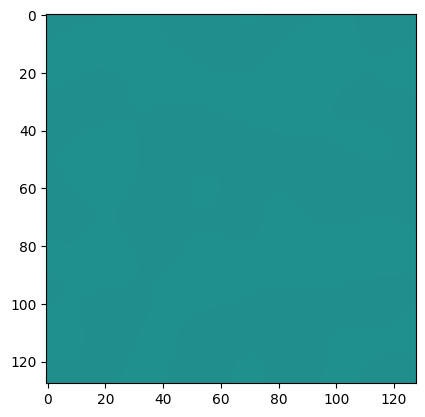

In [15]:
plt.imshow(solution.ys[-1], vmin=-1, vmax=1)

In [16]:
solution = diffrax.diffeqsolve(
    diffrax.ODETerm(jax.jit(lambda t, y, args: eq.rhs(y, t))),
    solver,
    t0=t_start,
    t1=t_final,
    dt0=dt,
    y0=u0,
    # stepsize_controller=diffrax.PIDController(rtol=1e-2, atol=1e-2),
    saveat=diffrax.SaveAt(ts=ts_save),
    max_steps=1000000,
)

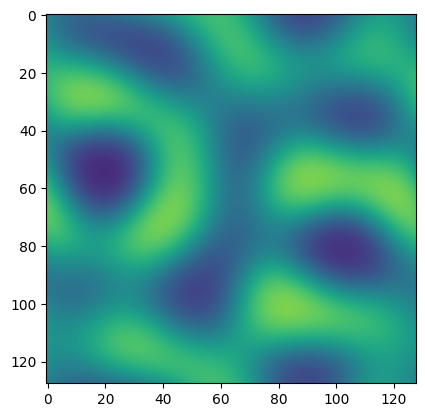

In [17]:
plt.imshow(solution.ys[-1], vmin=-1, vmax=1)

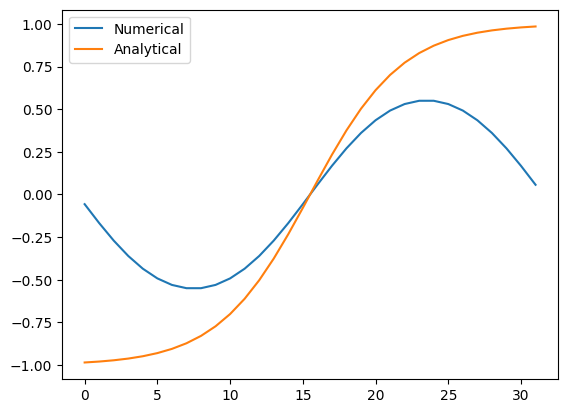

In [18]:
phi_analytic = np.tanh(domain.axes()[0] / np.sqrt(2 * kappa))
plt.plot(solution.ys[-1, :, 26].squeeze(), label="Numerical")
plt.plot(phi_analytic, label="Analytical")
plt.legend()
plt.show()

In [59]:
Nx, Ny = 128, 128
Lx = 0.01 * Nx
Ly = 0.01 * Ny
domain = Domain((Nx, Ny), ((-Lx / 2, Lx / 2), (-Ly / 2, Ly / 2)), "dimensionless")

t_start = 0.0
t_final = 10.0
dt = 0.000001

ts_save = jnp.linspace(t_start, t_final, 200)

kappa = 0.002

In [66]:
eq = AllenCahn2DPeriodic(
    domain, kappa, lambda c: jnp.log(c / (1.0 - c)) + 3.0 * (1.0 - 2.0 * c), lambda c: jnp.ones_like(c), derivs="fd"
)

# solver = diffrax.Tsit5()
# solver = diffrax.ImplicitEuler(
#     diffrax.with_stepsize_controller_tols(optx.Newton)(
#         linear_solver=lx.GMRES(
#             rtol=1e-3, atol=1e-3, restart=100, stagnation_iters=100
#         )
#     ),
#     root_find_max_steps=1000,
# )

solver = diffrax.ImplicitEuler(
    diffrax.with_stepsize_controller_tols(optx.Chord)(),
    root_find_max_steps=1000,
)

In [67]:
key = random.PRNGKey(0)
u0 = 0.5 * jnp.ones((Nx, Ny)) + 0.1 * random.normal(key, (Nx, Ny))

In [68]:
solution = diffrax.diffeqsolve(
    diffrax.ODETerm(jax.jit(lambda t, y, args: eq.rhs(y, t))),
    solver,
    t0=t_start,
    t1=t_final,
    dt0=dt,
    y0=u0,
    stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-6),
    saveat=diffrax.SaveAt(ts=ts_save),
    max_steps=1000000,
)

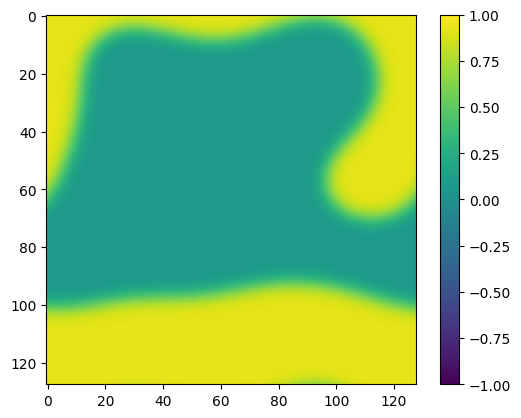

In [65]:
plt.imshow(solution.ys[-1], vmin=-1, vmax=1)
plt.colorbar()
plt.show()

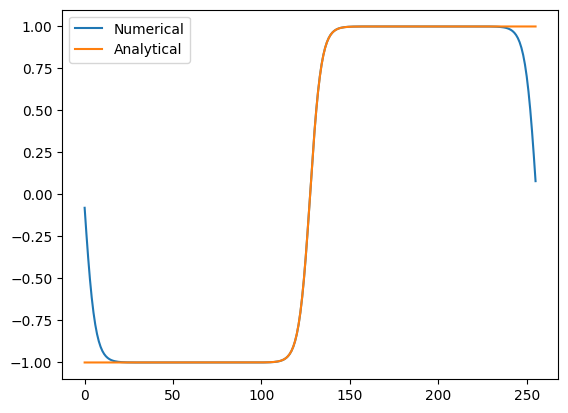

In [103]:
phi_analytic = np.tanh(domain.axes()[0] / np.sqrt(2 * kappa))
plt.plot(solution.ys[-1].squeeze(), label="Numerical")
plt.plot(phi_analytic, label="Analytical")
plt.legend()
plt.show()